In [1]:
from google.colab import files
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torchvision.transforms.functional import to_pil_image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.v2 as v2
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [3]:
data_path=path+"/Master Folder"

In [4]:
val_test_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=True), # resizing to the standard input size
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Augmentation
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [6]:
train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=f"{data_path}/valid", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_path}/test",  transform=val_test_transforms)

In [7]:
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(valid_dataset))
print("Number of test images:", len(test_dataset))


Number of training images: 1000
Number of validation images: 36
Number of test images: 38


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [9]:
len(train_loader), len(valid_loader), len(test_loader)

(32, 2, 2)

In [10]:
for i, (inputs, labels) in enumerate(test_loader):
    print(f"Batch {i+1} size: {inputs.size(0)}")


Batch 1 size: 32
Batch 2 size: 6


In [11]:
print("Class labels:", train_dataset.classes)

Class labels: ['Angry', 'Other', 'Sad', 'happy']


In [12]:
images, labels = next(iter(test_loader))
print(images.shape)
print(images[0].shape)
print(labels)


torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3])


In [13]:
np.max(np.array(images[0]))

np.float32(0.96862745)

In [14]:
class_names=train_dataset.classes

In [15]:
num_classes = len(class_names)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **DenseNet 121**

https://medium.com/deepkapha-notes/implementing-densenet-121-in-pytorch-a-step-by-step-guide-c0c2625c2a60

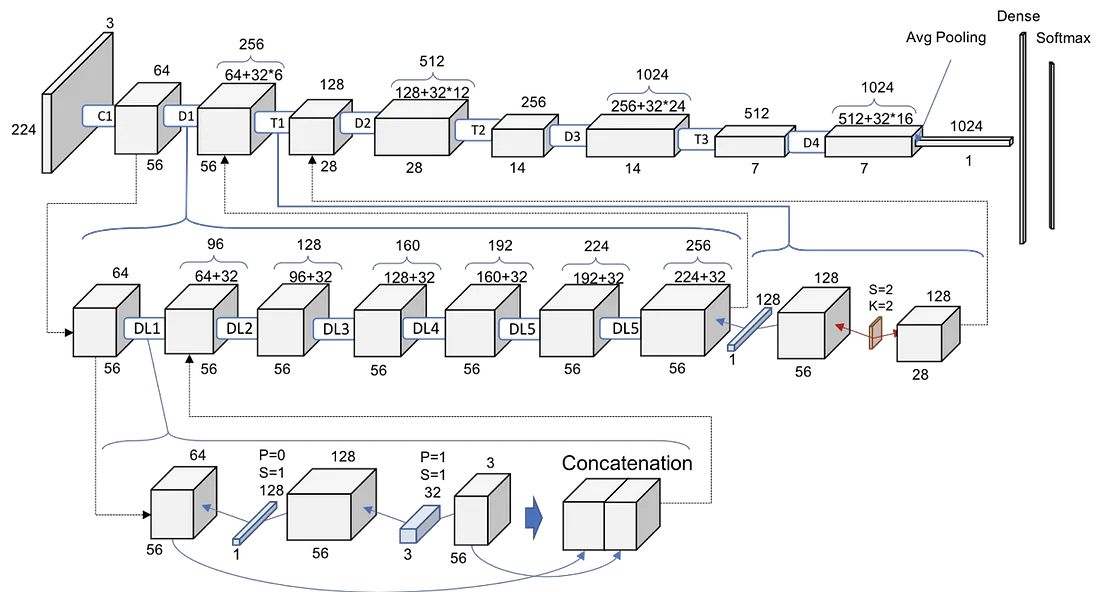

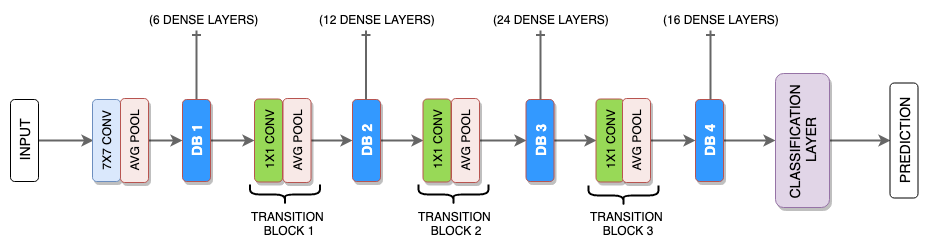

Notes:

- DenseBlock = x * DenseLayer
- DenseLayer = Conv1x1 + Conv3x3
- Conv = BatchNorm -> ReLU -> Conv



In [17]:
# 5. DenseNet121
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = drop_rate

    def forward(self, x):
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        return torch.cat([x, out], 1)


In [18]:
class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        x = self.pool(x)
        return x


In [20]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=num_classes, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0):
        super().__init__()

        # initial conv
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # Dense blocks
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.features.add_module(f'denseblock{i+1}', block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = num_features // 2

        # final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # classific
        self.classifier = nn.Linear(num_features, num_classes)

        # weights init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [21]:
model = DenseNet121(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(valid_dataset)
        val_acc = val_corrects.double() / len(valid_dataset)

        # metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted')

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        # best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_densenet121.pth')

    return model


In [23]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)



Epoch 1/50
----------
Train Loss: 1.4596 Acc: 0.2880
Val Loss: 7.7193 Acc: 0.1389
Precision: 0.0278, Recall: 0.1389, F1: 0.0463
Epoch 2/50
----------
Train Loss: 1.3906 Acc: 0.3150


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.4333 Acc: 0.2778
Precision: 0.1634, Recall: 0.2778, F1: 0.2053
Epoch 3/50
----------
Train Loss: 1.3828 Acc: 0.3170
Val Loss: 2.7143 Acc: 0.1944
Precision: 0.1091, Recall: 0.1944, F1: 0.1181
Epoch 4/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3730 Acc: 0.3030
Val Loss: 2.1720 Acc: 0.2778
Precision: 0.2685, Recall: 0.2778, F1: 0.2699
Epoch 5/50
----------
Train Loss: 1.3564 Acc: 0.3520
Val Loss: 2.7133 Acc: 0.2778
Precision: 0.1607, Recall: 0.2778, F1: 0.2032
Epoch 6/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3694 Acc: 0.3270


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 2.0493 Acc: 0.2500
Precision: 0.1644, Recall: 0.2500, F1: 0.1412
Epoch 7/50
----------
Train Loss: 1.3544 Acc: 0.3560
Val Loss: 3.8143 Acc: 0.2778
Precision: 0.2240, Recall: 0.2778, F1: 0.2449
Epoch 8/50
----------
Train Loss: 1.3448 Acc: 0.3610
Val Loss: 2.1394 Acc: 0.1111
Precision: 0.1466, Recall: 0.1111, F1: 0.1219
Epoch 9/50
----------
Train Loss: 1.3292 Acc: 0.3610
Val Loss: 3.4110 Acc: 0.1944
Precision: 0.2000, Recall: 0.1944, F1: 0.1565
Epoch 10/50
----------
Train Loss: 1.3170 Acc: 0.3640
Val Loss: 1.7760 Acc: 0.2500
Precision: 0.1722, Recall: 0.2500, F1: 0.2002
Epoch 11/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3233 Acc: 0.3720
Val Loss: 1.6809 Acc: 0.3056
Precision: 0.4494, Recall: 0.3056, F1: 0.2778
Epoch 12/50
----------
Train Loss: 1.3225 Acc: 0.3660
Val Loss: 1.6896 Acc: 0.3889
Precision: 0.4140, Recall: 0.3889, F1: 0.3830
Epoch 13/50
----------
Train Loss: 1.2977 Acc: 0.3970
Val Loss: 3.4084 Acc: 0.2778
Precision: 0.4306, Recall: 0.2778, F1: 0.2476
Epoch 14/50
----------
Train Loss: 1.2729 Acc: 0.3970
Val Loss: 1.7750 Acc: 0.3611
Precision: 0.3671, Recall: 0.3611, F1: 0.3503
Epoch 15/50
----------
Train Loss: 1.3050 Acc: 0.3890
Val Loss: 1.9130 Acc: 0.3056
Precision: 0.2463, Recall: 0.3056, F1: 0.2656
Epoch 16/50
----------
Train Loss: 1.2855 Acc: 0.3980
Val Loss: 1.7152 Acc: 0.3889
Precision: 0.2895, Recall: 0.3889, F1: 0.3227
Epoch 17/50
----------
Train Loss: 1.2912 Acc: 0.3920
Val Loss: 2.1323 Acc: 0.2500
Precision: 0.4484, Recall: 0.2500, F1: 0.2266
Epoch 18/50
----------
Train Loss: 1.2797 Acc: 0.3900
Val Loss: 2.0309 Acc: 0.2222
Precision: 0.3418, Recall: 0.2222, F1

In [24]:
# --- Evaluation Function ---
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = sum(1 for x,y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Test Accuracy: 0.3684
Precision: 0.3705
Recall: 0.3684
F1 Score: 0.3610


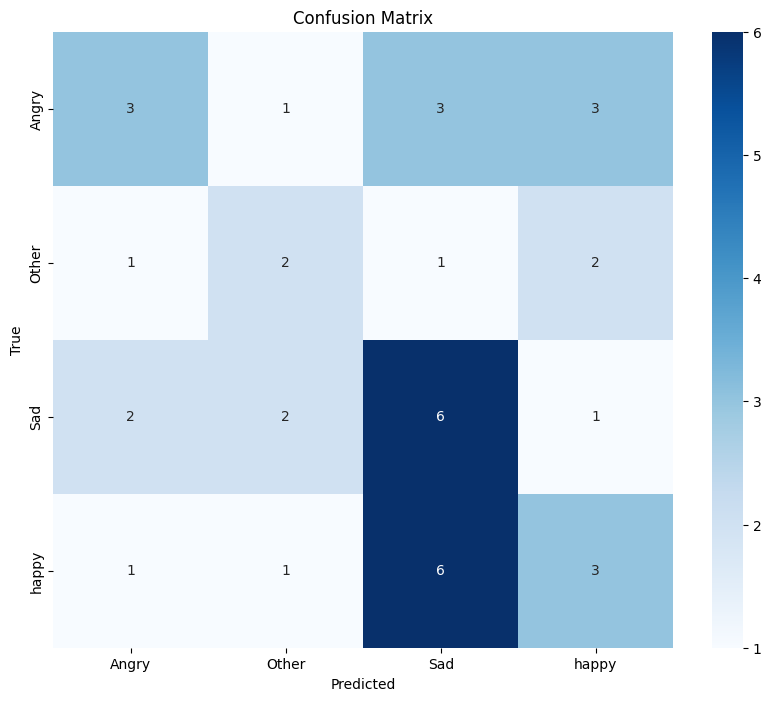

In [25]:
model.load_state_dict(torch.load('best_densenet121.pth'))
evaluate_model(model, test_loader)